# k-Nearest Neighbor (kNN) 练习

kNN分类器分为两个阶段:

- 在训练过程中，分类器获取训练数据并简单地记住它
- 在测试过程中，kNN将每个测试图像与所有的训练图像进行比较，并将k个最相似的训练实例的标签进行转移，从而对每个测试图像进行分类
- k的值是交叉验证的

在本练习中，您将实现这些步骤并了解基本的图像分类管道、交叉验证，并熟练地编写高效的向量化代码。

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # 设置图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
from pathlib import Path
Path("cs231n/datasets/cifar-10-batches-py").mkdir(parents=True, exist_ok=True)
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'   #注意在不同系统中路径表示
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


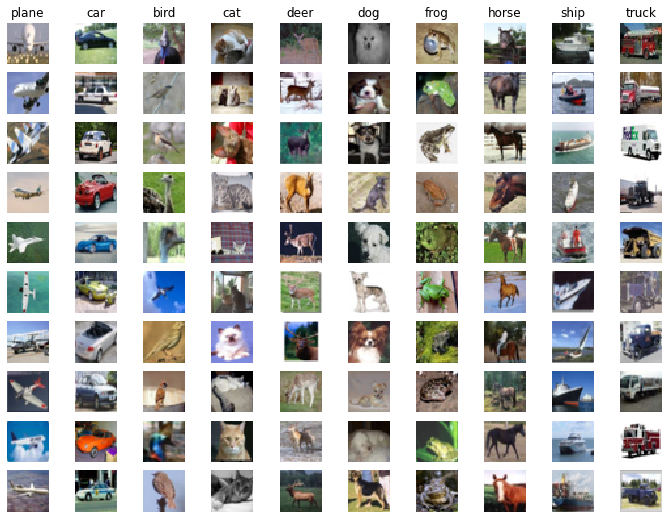

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10      #展示个数可以自定
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

我们现在想用kNN分类器对测试数据进行分类。我们可以把这个过程分成两个步骤:
1. 首先，我们必须计算所有测试样例和所有训练样例之间的距离。
2. 给定这些距离，对于每个测试示例，我们找到k个最近的示例，并让它们为标签投票
让我们从计算所有训练和测试示例之间的距离矩阵开始。例如，如果用**Ntr**代表训练示例和**Nte**代表测试示例，则此阶段将生成一个**Nte x Ntr**矩阵，其中每个元素(i,j)是第i个测试和第j个训练示例之间的距离。
首先,打开`cs231n/classifiers/k_nearest_neighbor.py` ，并实现函数`compute_distances_two_loops`，该函数对所有对(test, train) 示例使用(非常低效的)双循环，并一次计算一个元素的距离矩阵。

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print (dists.shape)

(500, 5000)


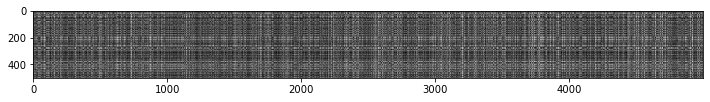

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** 注意距离矩阵中的结构化模式，其中一些行或列更亮。(注意，在默认的配色方案中，黑色表示低距离，白色表示高距离。)
- 数据中那些明显明亮的行背后的原因是什么?
- 是什么导致了这些列?

**Your Answer**: *fill this in.*
1. 测试数据和原始距离偏差很大，可能是异常值
2. 训练数据中有异常值，坏点


In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


你应该期望看到大约`27%`的准确率。现在让我们尝试一个更大的`k`，比如`k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


你应该期望看到比`k = 1`稍微好一点的性能。

In [11]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print ('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print ('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print ('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 52.434083 seconds
One loop version took 76.348480 seconds
No loop version took 0.425506 seconds


### 交叉验证
我们已经实现了k近邻分类器，但是我们随意设置了k = 5的值。现在我们将通过交叉验证来确定这个超参数的最佳值。

In [14]:
num_folds = 10
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
for k in k_choices:
    accuracies = []
    for j in range(num_folds):
        X_v = X_train_folds[j]
        y_v = y_train_folds[j]
        X_tr = np.vstack(X_train_folds[0:j] + X_train_folds[j+1:])
        y_tr = np.hstack(y_train_folds[0:j] + y_train_folds[j+1:])
        
        classifier.train(X_tr, y_tr)
        dists = classifier.compute_distances_no_loops(X_v)
        y_test_pred = classifier.predict_labels(dists, k)
        num_correct = np.sum(y_test_pred == y_v)
        accuracies.append(float(num_correct) * num_folds / num_training)
        k_to_accuracies[k] = accuracies

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print ('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.254000
k = 1, accuracy = 0.268000
k = 1, accuracy = 0.256000
k = 1, accuracy = 0.272000
k = 1, accuracy = 0.270000
k = 1, accuracy = 0.282000
k = 1, accuracy = 0.274000
k = 1, accuracy = 0.282000
k = 1, accuracy = 0.272000
k = 1, accuracy = 0.280000
k = 3, accuracy = 0.232000
k = 3, accuracy = 0.258000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.246000
k = 3, accuracy = 0.246000
k = 3, accuracy = 0.252000
k = 3, accuracy = 0.278000
k = 3, accuracy = 0.248000
k = 3, accuracy = 0.228000
k = 3, accuracy = 0.268000
k = 5, accuracy = 0.226000
k = 5, accuracy = 0.258000
k = 5, accuracy = 0.284000
k = 5, accuracy = 0.250000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.270000
k = 5, accuracy = 0.284000
k = 5, accuracy = 0.276000
k = 5, accuracy = 0.252000
k = 5, accuracy = 0.306000
k = 8, accuracy = 0.242000
k = 8, accuracy = 0.268000
k = 8, accuracy = 0.294000
k = 8, accuracy = 0.260000
k = 8, accuracy = 0.286000
k = 8, accuracy = 0.288000
k = 8, accuracy = 0.280000
k

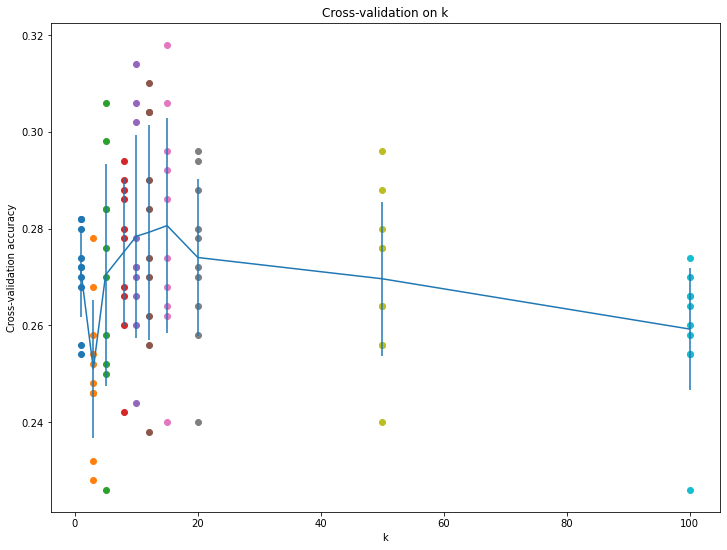

In [15]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [16]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
